<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_8_1_sine_wave_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 8.1
## Sinus forecasting
In this task, we will learn to implement RNNs in Keras.
Therefore:
 - Run the provided script and comment on the output.
 - Vary the number and size of the LSTM layers and compare training time and stability of the performance.

The goal of this task is to predict the next value of a sine function. This is a special case because the output of the network (the `y` value) should correponds to the next input `x` value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

print(keras.__version__)

2.10.0


### Generation of data
We start by creating a signal trace: `t = 0-100`, `f = sin(pi * t)`

In [2]:
N = 10000
t = np.linspace(0, 100, N)  # time steps
f = np.sin(np.pi * t)  # signal

Split into semi-redundant sub-sequences of `length = window_size + 1` and perform shuffle

In [3]:
window_size = 20
n = N - window_size - 1  # number of possible splits
print(f"generating {n} semi redundant sub-sequences with size {window_size+1}.")
data = np.stack([f[i: i + window_size + 1] for i in range(n)])
print(data.shape)

generating 9979 semi redundant sub-sequences with size 21.
(9979, 21)


Finally, split the data into features. The `x` values are the first 20 data points of a sequence. The `y` value is the corresponding next value in the sequence.

In [4]:
X, y = np.split(data, [-1], axis=1)

# as always, another dimension is added to the input vector
# because the KERAS library also allows for multiple inputs per time step.
# In our case here, we have just one input value per time stamp.
X = X[..., np.newaxis]
print(X.shape)
print(y.shape)
print('Example:')
print('X =', X[0, :, 0])
print('y =', y[0, :])

(9979, 20, 1)
(9979, 1)
Example:
X = [0.         0.0314139  0.06279679 0.0941177  0.1253457  0.15644998
 0.18739983 0.21816471 0.24871423 0.27901826 0.30904688 0.33877044
 0.36815961 0.39718538 0.42581909 0.45403249 0.48179773 0.50908739
 0.53587454 0.56213275]
y = [0.58783609]


### Define and train RNN

In [45]:
z0 = layers.Input(shape=[None, 1])
z = layers.LSTM(6, return_sequences=True)(z0)
z = layers.LSTM(6, return_sequences=True)(z)
z = layers.LSTM(6, return_sequences=True)(z)
z = layers.LSTM(6)(z)
z = layers.Dense(1)(z)
model = keras.models.Model(inputs=z0, outputs=z)
print(model.summary())

model.compile(loss='mse', optimizer='adam')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm_19 (LSTM)              (None, None, 6)           192       
                                                                 
 lstm_20 (LSTM)              (None, None, 6)           312       
                                                                 
 lstm_21 (LSTM)              (None, None, 6)           312       
                                                                 
 lstm_22 (LSTM)              (None, 6)                 312       
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,135
Trainable params: 1,135
Non-trainable p

In [46]:
results = model.fit(X, y,
    epochs=60,
    batch_size=32,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=4, verbose=1)])

Epoch 1/60
281/281 - 9s - loss: 0.0749 - val_loss: 0.0068 - lr: 0.0010 - 9s/epoch - 32ms/step
Epoch 2/60
281/281 - 3s - loss: 0.0024 - val_loss: 5.3085e-04 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 3/60
281/281 - 4s - loss: 2.7457e-04 - val_loss: 1.3693e-04 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 4/60
281/281 - 4s - loss: 1.5278e-04 - val_loss: 1.0347e-04 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 5/60
281/281 - 4s - loss: 1.0674e-04 - val_loss: 9.0519e-05 - lr: 0.0010 - 4s/epoch - 12ms/step
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
281/281 - 4s - loss: 8.8764e-05 - val_loss: 5.9560e-05 - lr: 0.0010 - 4s/epoch - 12ms/step
Epoch 7/60
281/281 - 4s - loss: 7.3669e-05 - val_loss: 5.7395e-05 - lr: 6.7000e-04 - 4s/epoch - 13ms/step
Epoch 8/60
281/281 - 3s - loss: 5.6986e-05 - val_loss: 6.1244e-05 - lr: 6.7000e-04 - 3s/epoch - 12ms/step
Epoch 9/60

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
281/281 - 4s - loss: 5.

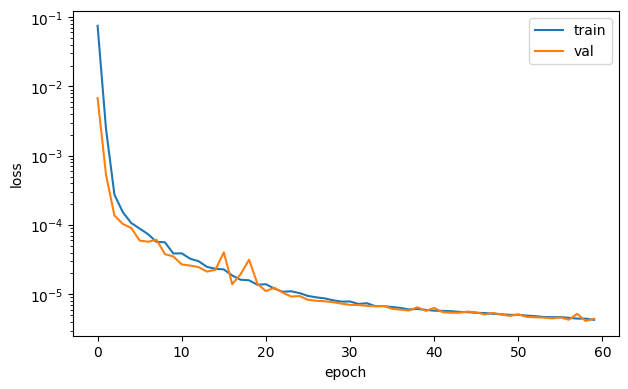

In [47]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

### Evaluate the model
Investigate the forecasting capabilities of the model.

In [41]:
def predict_next_k(model, window, k=10):
    """Predict next k steps for the given model and starting sequence """
    x = window[np.newaxis, :, np.newaxis]  # initial input
    y = np.zeros(k)
    for i in range(k):
        y[i] = model.predict(x, verbose=0)
        # create the new input including the last prediction
        x = np.roll(x, -1, axis=1)  # shift all inputs 1 step to the left
        x[:, -1] = y[i]  # add latest prediction to end
    return y

In [42]:
def plot_prediction(i0=0, k=500):
    """ Predict and plot the next k steps for an input starting at i0 """
    y0 = f[i0: i0 + window_size]  # starting window (input)
    y1 = predict_next_k(model, y0, k)  # predict next k steps

    t0 = t[i0: i0 + window_size]
    t1 = t[i0 + window_size: i0 + window_size + k]

    plt.figure(figsize=(12, 4))
    plt.plot(t, f, label='data')
    plt.plot(t0, y0, color='C1', lw=3, label='prediction')
    plt.plot(t1, y1, color='C1', ls='--')
    plt.xlim(0, 10)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')

C:\Users\Abbe\AppData\Local\Temp\ipykernel_9900\328717723.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = model.predict(x, verbose=0)


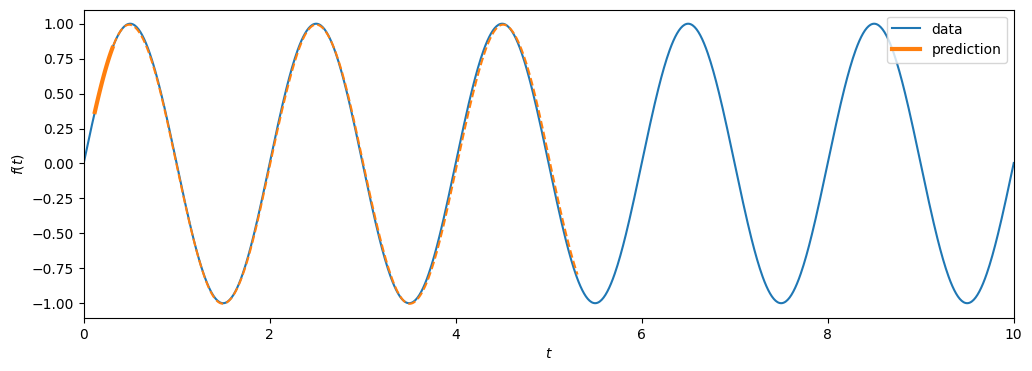

In [48]:
plot_prediction(12)

C:\Users\Abbe\AppData\Local\Temp\ipykernel_9900\328717723.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = model.predict(x, verbose=0)


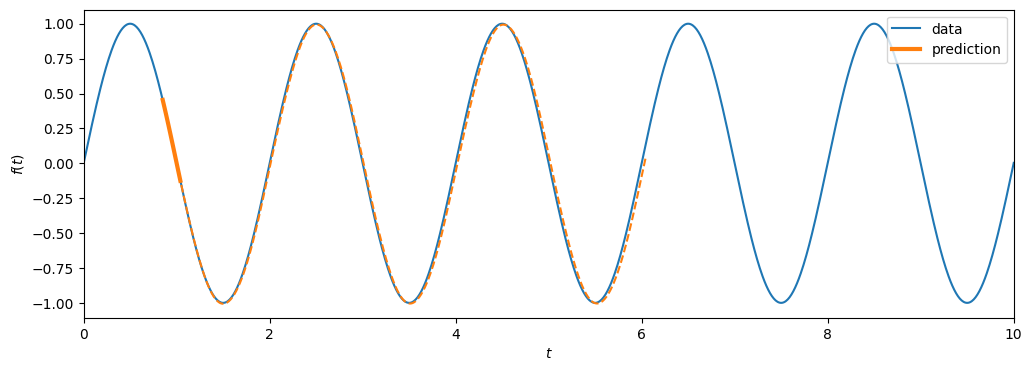

In [49]:
plot_prediction(85)

C:\Users\Abbe\AppData\Local\Temp\ipykernel_9900\328717723.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = model.predict(x, verbose=0)


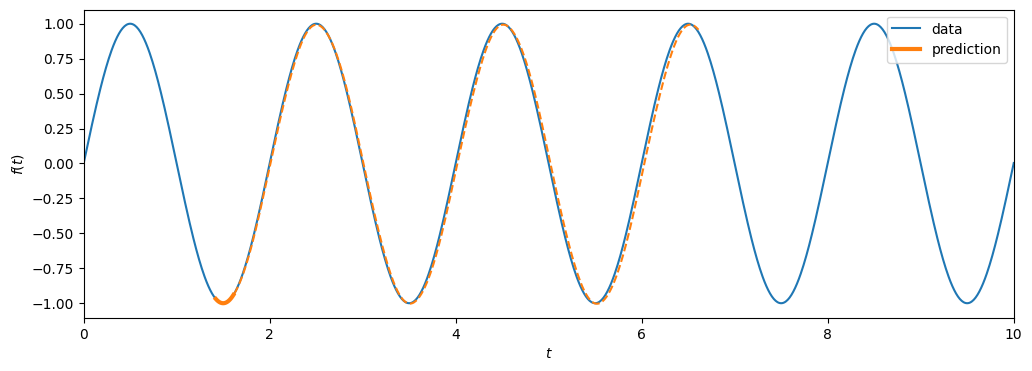

In [50]:
plot_prediction(142)

## Notes
For one LSTM layer of size 16:
- 1s/epoch training
- e-7 loss
- Not fully trained after 60 epochs
- Accurately predicts sine from any starting sequence

One layer with 3 nodes:
- 2s/epoch training (slower/equal as size 16!)
- e-5 loss
- closer to plateau after 60 epochs than size 16
- captures the periodicity but not the shape of the sine wave
- is better at predicting monotone part rather than peaks
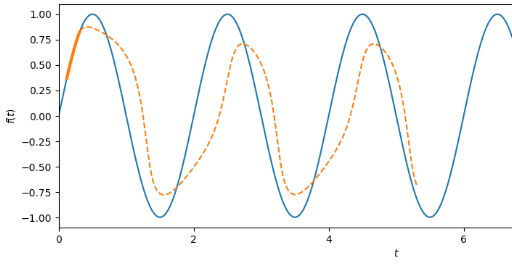

Two layers with 3 nodes:
- 2s/epoch training
- e-5 loss
- closer to plateau after 60 epochs than size 16
- decent prediction, not as good as one layer 16.
- equally good from any start

Four layers with 6 nodes:
- 4s/epoch training
- e-6 loss
- can use some more training than 60 epochs
- Stable and accurate predictions

For this particular problem, a one 16 node layer is enough for an accurate model.
